### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

### Loading Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df.set_index('PassengerId', inplace=True)
test_df.set_index('PassengerId', inplace=True)

### Functions to help speed up data processing

In [5]:
def fill_null(col, value, tr_df=train_df, te_df=test_df, ):
    """Fill in null values for both dataframes"""
    tr_df[col] = tr_df[col].fillna(value)
    te_df[col] = te_df[col].fillna(value)
    return (tr_df, te_df)

In [6]:
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

In [7]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


### Dealing with missing values

In [8]:
print(train_df.isnull().sum())
test_df.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64


HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

In [9]:
"""Set to a string value of 'Unknown'"""
train_df, test_df = fill_null('HomePlanet', 'Unknown')

In [10]:
"""Assume that it's just false"""
train_df, test_df = fill_null('CryoSleep', False)

In [11]:
train_df['Cabin'].unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [12]:
"""For this one I will make a cabin id that follows the same form because I want to later try 
and extract some info from this column"""
unknown_cabin_id = 'N/0/N'
train_df, test_df = fill_null('Cabin', unknown_cabin_id)

In [13]:
train_df['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [14]:
"""For this one I will also just make this 'Unknown'"""
train_df, test_df = fill_null('Destination', 'Unknown')

In [15]:
train_df['Age'].nunique()

80

In [16]:
"""For age I will take the average age of all the passengers and set the null values to this average"""
average_age = pd.concat([train_df['Age'], test_df['Age']]).mean()
train_df, test_df = fill_null('Age', average_age)

In [17]:
"""I will assume if there is no value for VIP then it would just be false"""
train_df, test_df = fill_null('VIP', False)

In [18]:
"""For RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck if there is no value I will just assume 
that there was no spending and it would be 0"""
lst_of_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in lst_of_cols:
    train_df,test_df = fill_null(col, 0)


### Feature Engineering/Data Proccessing

In [19]:
"""In the Cabin column the form of the id goes deck/num/side. 
I will make 3 new columns which has each of those values just in seperate columns"""

train_df[['Deck', 'Number', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Number', 'Side']] = test_df['Cabin'].str.split('/', expand=True)
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [20]:
"""One hot encoding for 2 of the new columns"""
train_dummies = pd.get_dummies(train_df[['Deck', 'Side']], dtype=int)
test_dummies = pd.get_dummies(test_df[['Deck', 'Side']], dtype=int)

In [21]:
train_df = pd.concat([train_df, train_dummies], axis=1)
test_df = pd.concat([test_df, test_dummies], axis=1)
train_df.drop(['Deck', 'Side'], axis=1, inplace=True)
test_df.drop(['Deck', 'Side'], axis=1, inplace=True)

In [22]:
""" The last feature I will engineer is a total spend that just combines the spending from the 
RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck columns"""
train_df['TotalSpend'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_df['TotalSpend'] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [23]:
"""Now I will just do one-hot encoding for the rest of the categorical columns"""

train_dummies = pd.get_dummies(train_df[['HomePlanet', 'Destination']], dtype=int)
test_dummies = pd.get_dummies(test_df[['HomePlanet', 'Destination']], dtype=int)

In [24]:
train_df = pd.concat([train_df, train_dummies], axis=1)
test_df = pd.concat([test_df, test_dummies], axis=1)

In [25]:
train_df.drop(['HomePlanet', 'Destination'], axis=1, inplace=True)
test_df.drop(['HomePlanet', 'Destination'], axis=1, inplace=True)

In [26]:
lst_of_cols = ['CryoSleep', 'VIP']
for col in lst_of_cols:
    train_df[col] = train_df[col].apply(lambda x: 1 if x == True else 0)
    test_df[col] = test_df[col].apply(lambda x: 1 if x == True else 0)
train_df['Transported'] = train_df['Transported'].apply(lambda x: 1 if x == True else 0)

In [27]:
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,...,Side_S,TotalSpend,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0.0,0,1,0,0,0,0,1,0
0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,1,736.0,1,0,0,0,0,0,1,0
0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,...,1,10383.0,0,1,0,0,0,0,1,0
0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,1,5176.0,0,1,0,0,0,0,1,0
0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,...,1,1091.0,1,0,0,0,0,0,1,0


### Data Exploration

In [28]:
np.abs(train_df.corr()['Transported']) > 0.10

CryoSleep                     True
Age                          False
VIP                          False
RoomService                   True
FoodCourt                    False
ShoppingMall                 False
Spa                           True
VRDeck                        True
Transported                   True
Number                       False
Deck_A                       False
Deck_B                        True
Deck_C                        True
Deck_D                       False
Deck_E                       False
Deck_F                       False
Deck_G                       False
Deck_N                       False
Deck_T                       False
Side_N                       False
Side_P                        True
Side_S                        True
TotalSpend                    True
HomePlanet_Earth              True
HomePlanet_Europa             True
HomePlanet_Mars              False
HomePlanet_Unknown           False
Destination_55 Cancri e       True
Destination_PSO J318

<Axes: >

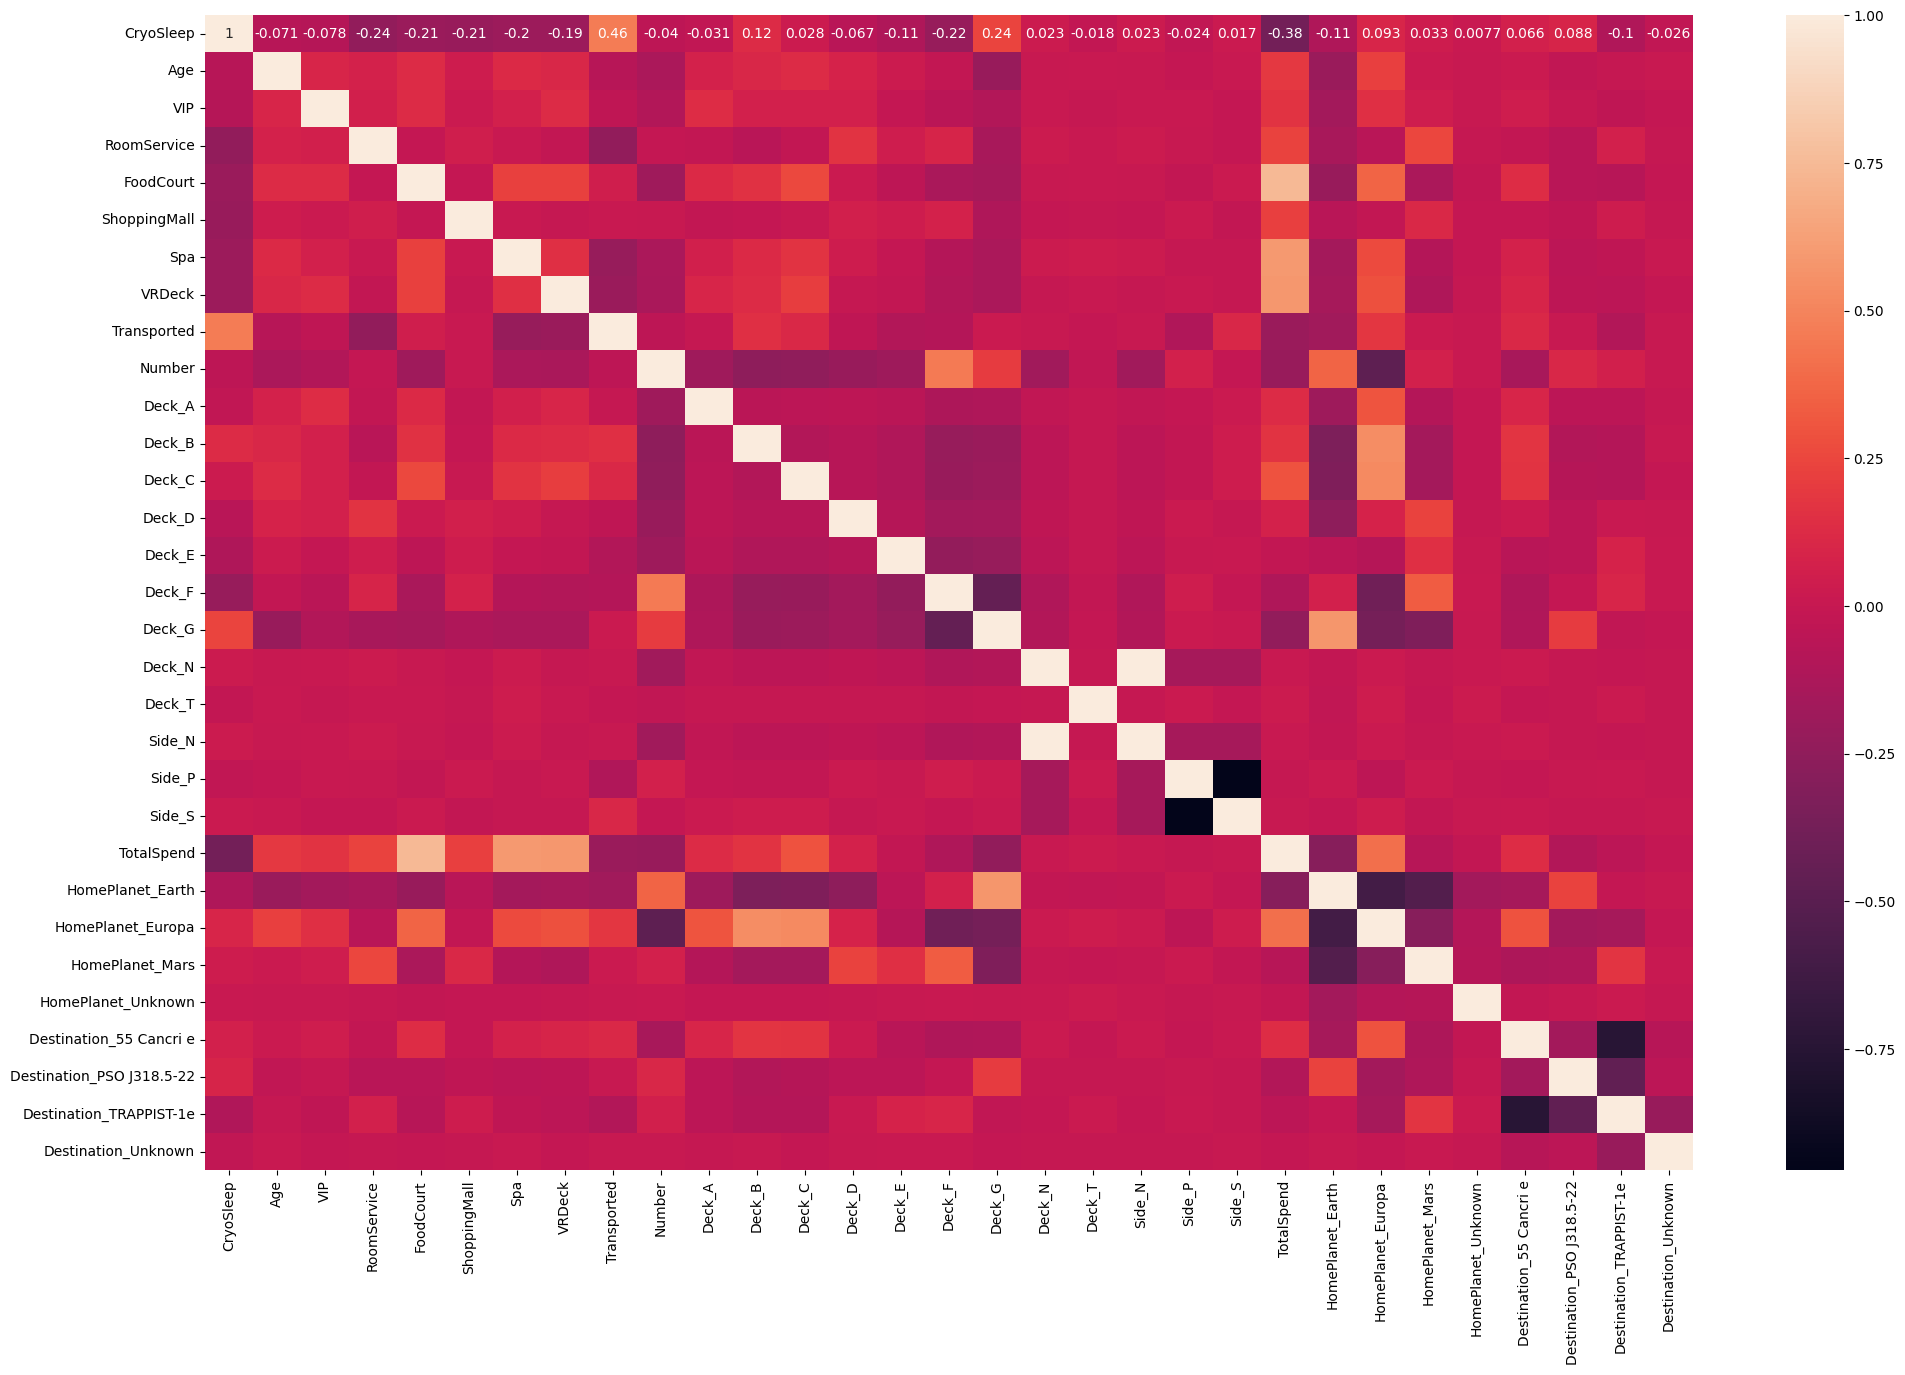

In [29]:
plt.figure(figsize=(24,15))
sns.heatmap(train_df.corr(), annot=True)

### Scaling and Spliting Data

In [30]:
X_train = train_df.drop('Transported', axis=1)
X_test = test_df
y_train = train_df['Transported']


In [31]:
scaler = MinMaxScaler()

In [32]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Decision Tree Classifier

In [33]:
param_grid = {  
    'max_depth': [16, 17, 18],   
    'min_samples_split': [20, 21, 22]  
}

In [34]:
dtc = DecisionTreeClassifier(max_features=None, criterion='entropy', min_samples_leaf=3,
                            splitter='random', min_samples_split=22, max_depth=17)

In [35]:
grid_search = GridSearchCV(dtc, param_grid, cv=5)
"""Keep changing param grid based on results until I find the best params"""

'Keep changing param grid based on results until I find the best params'

In [36]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                              min_samples_leaf=3,
                                              min_samples_split=22,
                                              splitter='random'),
             param_grid={'max_depth': [16, 17, 18],
                         'min_samples_split': [20, 21, 22]})

In [37]:
grid_search.best_params_

{'max_depth': 18, 'min_samples_split': 21}

In [38]:
dtc.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_leaf=3,
                       min_samples_split=22, splitter='random')

In [39]:
predictions = dtc.predict(X_test_scaled)

In [40]:
output_array = predictions.astype(bool)

print(output_array)

[False False  True ...  True  True False]


In [41]:
final_ouput = {
    'PassengerId':test_df.index,
    'Transported':output_array
}

In [42]:
submission = pd.DataFrame(final_ouput)

In [43]:
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [44]:
submission.to_csv('dtc_predictions.csv', index_label=False, index=False)

#### The DTC model got a score of 78.40% 

### K-Nearest Neighbors 

In [45]:
param_grid = {         
    'leaf_size': [1, 2, 3]
}

In [46]:
knnc = KNeighborsClassifier(p=1, n_neighbors=10, weights='uniform', leaf_size=1)

In [47]:
grid_search = GridSearchCV(knnc, param_grid, cv=3)

In [48]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=1),
             param_grid={'leaf_size': [1, 2, 3]})

In [49]:
grid_search.best_params_

{'leaf_size': 1}

In [50]:
knnc.fit(X_train_scaled, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=1)

In [51]:
predictions = knnc.predict(X_test_scaled)

In [52]:
output_array = predictions.astype(bool)

In [53]:
final_ouput = {
    'PassengerId':test_df.index,
    'Transported':output_array
}

In [54]:
submission = pd.DataFrame(final_ouput)

In [55]:
submission.to_csv('knn_predictions.csv', index_label=False, index=False)

#### The KNN model got a score of 75.54%

### Neural Network

#### Basic NN

In [ ]:
model = Sequential()

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
early_stop = EarlyStopping(monitor='accuracy', patience=1)

In [58]:
model.fit(X_train_scaled, y_train, epochs=100, callbacks=[early_stop])

Epoch 1/100
272/272 [==============================] - 1s 606us/step - loss: 0.5504 - accuracy: 0.7175
Epoch 2/100
272/272 [==============================] - 0s 585us/step - loss: 0.4820 - accuracy: 0.7587
Epoch 3/100
272/272 [==============================] - 0s 585us/step - loss: 0.4566 - accuracy: 0.7751
Epoch 4/100
272/272 [==============================] - 0s 574us/step - loss: 0.4388 - accuracy: 0.7850
Epoch 5/100
272/272 [==============================] - 0s 580us/step - loss: 0.4313 - accuracy: 0.7799


In [59]:
predictions = model.predict(X_test_scaled)

134/134 [==============================] - 0s 445us/step


In [60]:
y_pred = (predictions >= 0.5).astype(bool)

In [61]:
final_ouput = {
    'PassengerId':test_df.index,
    'Transported':y_pred.ravel()
}

In [62]:
y_pred.ravel()

array([ True, False,  True, ...,  True,  True,  True])

In [63]:
submission = pd.DataFrame(final_ouput)

In [64]:
submission.to_csv('basic_nn_predictions.csv', index_label=False, index=False)

#### The score of the Basic Nerual Network was 79.66%

### Complex Neural Network

Based on the correlation we saw before I want to try and take some features that have higher correlation and try to make branches in the model to process these seperatly and try to get a higher score and maybe get in the 80 percentile. 

In [65]:
"""Split data even more"""

X_train_home = X_train[['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown']]
X_train_spending = X_train[['TotalSpend', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
X_train_destination = X_train[['Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_Unknown']]
X_train_rest = X_train.drop(['Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_Unknown',
                            'TotalSpend', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown'], axis=1)

X_test_home = X_test[['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown']]
X_test_spending = X_test[['TotalSpend', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
X_test_destination = X_test[['Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_Unknown']]
X_test_rest = X_test.drop(['Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Destination_Unknown',
                            'TotalSpend', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown'], axis=1)

In [66]:
scaler_home = MinMaxScaler()
scaler_spending = MinMaxScaler()
scaler_destination = MinMaxScaler()
scaler_rest = MinMaxScaler()

In [67]:
X_train_home = scaler_home.fit_transform(X_train_home)
X_train_spending = scaler_spending.fit_transform(X_train_spending)
X_train_destination = scaler_destination.fit_transform(X_train_destination)
X_train_rest = scaler_rest.fit_transform(X_train_rest)

In [68]:
X_test_home = scaler_home.transform(X_test_home)
X_test_spending = scaler_spending.transform(X_test_spending)
X_test_destination = scaler_destination.transform(X_test_destination)
X_test_rest = scaler_rest.transform(X_test_rest)

In [69]:
input_home = Input(shape=(X_train_home.shape[-1],))
input_spending = Input(shape=(X_train_spending.shape[-1],))
input_destination = Input(shape=(X_train_destination.shape[-1],))
input_rest = Input(shape=(X_train_rest.shape[-1],))

In [70]:
branch_home = Dense(100, activation='relu')(input_home)
branch_home = Dropout(0.2)(input_home)
branch_home = Dense(50, activation='relu')(input_home)

branch_spending = Dense(100, activation='relu')(input_spending)
branch_spending = Dropout(0.2)
branch_spending = Dense(50, activation='relu')(input_spending)

branch_destination = Dense(100, activation='relu')(input_destination)
branch_destination = Dropout(0.2)(input_destination)
branch_destination = Dense(50, activation='relu')(input_destination)

branch_rest = Dense(150, activation='relu')(input_rest)
branch_rest = Dropout(0.2)(input_rest)
branch_rest = Dense(100, activation='relu')(input_rest)
branch_rest = Dropout(0.2)(input_rest)
branch_rest = Dense(50, activation='relu')(input_rest)

In [71]:
merged = Concatenate()([branch_home, branch_spending, branch_destination, branch_rest])

In [72]:
merged = Dense(50, activation='relu')(merged)

In [73]:
output = Dense(1, activation='sigmoid')(merged)

In [74]:
model = Model(inputs=[input_home, input_spending, input_destination, input_rest], outputs=output)

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                              

In [76]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [77]:
model.fit([X_train_home, X_train_spending, X_train_destination, X_train_rest], y_train, epochs=100, callbacks=[early_stop])

Epoch 1/100
272/272 [==============================] - 1s 740us/step - loss: 0.5245 - accuracy: 0.7389
Epoch 2/100
272/272 [==============================] - 0s 706us/step - loss: 0.4293 - accuracy: 0.7874
Epoch 3/100
272/272 [==============================] - 0s 679us/step - loss: 0.4187 - accuracy: 0.7965
Epoch 4/100
272/272 [==============================] - 0s 718us/step - loss: 0.4092 - accuracy: 0.8024
Epoch 5/100
272/272 [==============================] - 0s 696us/step - loss: 0.4040 - accuracy: 0.8034
Epoch 6/100
272/272 [==============================] - 0s 694us/step - loss: 0.4006 - accuracy: 0.8069
Epoch 7/100
272/272 [==============================] - 0s 702us/step - loss: 0.3977 - accuracy: 0.8100
Epoch 8/100
272/272 [==============================] - 0s 698us/step - loss: 0.3968 - accuracy: 0.8086


In [78]:
predictions = model.predict([X_test_home, X_test_spending, X_test_destination, X_test_rest])

134/134 [==============================] - 0s 463us/step


In [79]:
y_pred = (predictions >= 0.5).astype(bool)

In [80]:
final_ouput = {
    'PassengerId':test_df.index,
    'Transported':y_pred.ravel()
}

In [81]:
submission = pd.DataFrame(final_ouput)

In [82]:
submission.to_csv('complex_nn_predictions.csv', index_label=False, index=False)

#### The Score was 80.5%